# **Performance of Gradient Boosting Algorithms on a Image Dataset**

# This Notebook contains the comparative analysis of 3 Boosting Algorithms -
XGBoost, CatBoost and LightGBM trained and tested on a Image Dataset

In [ ]:
!pip install xgboost --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install hyperopt --quiet

     |████████████████████████████████| 64.8MB 61kB/s 


In [ ]:
from keras.datasets import cifar10
from sklearn import metrics
import catboost as ctb
from sklearn.model_selection import cross_val_score    

import time
start_time = time.time()
import numpy as np
import pandas as pd
#import sys
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import lightgbm as lgb
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import keras
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import pickle
import sys
import os

#
# TAKEN FROM https://keras.io/examples/cifar10_cnn/
# but with load_data() pulled out to work with your own cifar data set
#

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = '/content/drive/My Drive/IBM/cifar-10-batches-py'

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1,1):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if K.image_data_format() == 'channels_last':
        x_train_local = x_train_local.transpose(0, 2, 3, 1)
        x_test_local = x_test_local.transpose(0, 2, 3, 1)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [ ]:
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


# **Preprocess the data**

In [ ]:
X_train = X_train[:10000] ### Slicing to the required size #####
y_train = y_train[:10000]
X_test = X_test[:200]
y_test = y_test[:200]

In [ ]:
X_train.shape

(10000, 32, 32, 3)

In [ ]:
X_test.shape

(200, 32, 32, 3)

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [1],
       [1],
       [5]], dtype=uint8)

In [ ]:
 # X_train is 50000 rows of 3x32x32 values --> reshaped in 50000 x 3072
RESHAPED = 3072

X_train = X_train.reshape(10000, RESHAPED)
X_test = X_test.reshape(200, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
  # normalize the datasets
X_train /= 255.
X_test /= 255.

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

10000 train samples
200 test samples


In [ ]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer() 
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

# **Fit CatBoost model to the data**

In [ ]:
cb_hps = {  
            'learning_rate':      hp.loguniform('learning_rate', -5.0, -2.3),
            'depth':              hp.choice('depth',np.arange(5,16,1,dtype = int)),
            'l2_leaf_reg':       hp.quniform('l2_leaf_reg',2, 16, 1),
            'random_seed':       hp.choice('random_seed',np.arange(5, 10, 1,dtype=int)),
            'colsample_bylevel': hp.quniform('colsample_bylevel',0.3, 0.8, 0.1),
            'n_estimators':      hp.choice('n_estimators',np.arange(100,160,10,dtype = int))
        }

depth_list = [i for i in range(5,16,1)]
est_list = [i for i in range(100,160,10)]
## Manual Best till date Checkpoint ##
# params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
# params['metric'] = ['auc', 'binary_logloss']

In [ ]:
accuracy_list_cb = []
#cat_features = np.where(X_train.dtypes!=float)[0]
def HPO_cb(cb_hps):
    num_round = 50
    model = CatBoostClassifier(**cb_hps,silent = True)
    model.fit(X_train,y_train)
    pred = model.predict_proba(X_test)[:,1]
    for i in range(0,len(pred)): 
      if pred[i] >=0.5:
          pred[i] = 1
      else:
          pred[i] = 0
    accuracy_cb = accuracy_score(y_test,pred).mean()
    accuracy_list_cb.append(accuracy_cb)
    return {'loss': -accuracy_cb, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_cb = fmin(fn= HPO_cb,
            space= cb_hps,
            algo= tpe.suggest,
            max_evals = 1,
            trials = trials
            )
max_acc_cb = max(accuracy_list_cb)
print("Best Hyperparameters for CatBoost are: \n")
best_cb

100%|██████████| 1/1 [36:55<00:00, 2215.11s/it, best loss: -0.1]
Best Hyperparameters for CatBoost are: 



{'colsample_bylevel': 0.5,
 'depth': 4,
 'l2_leaf_reg': 9.0,
 'learning_rate': 0.03490643364050493,
 'n_estimators': 0,
 'random_seed': 0}

Best n_estimators   =   100
Best random_seed   =   5
Best learning_rate   =   0.03490643364050493
Best depth   =   9
Best l2_leaf_reg   =   9.0
Best colsample_bylevel   =   0.5


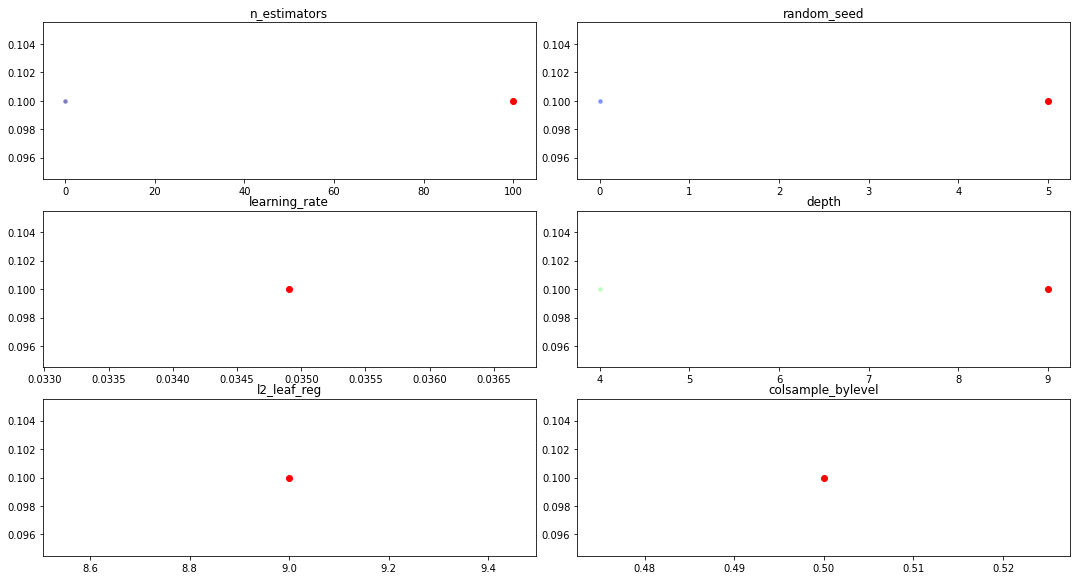

In [ ]:
parameters = ['n_estimators','random_seed','learning_rate','depth','l2_leaf_reg','colsample_bylevel']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'depth':
      best_cb[val] = depth_list[best_cb[val]]
    elif val == 'n_estimators':
      best_cb[val] = est_list[best_cb['n_estimators']]
    elif val == 'random_seed':
      best_cb[val]+=5
    print("Best " + str(val) + "   =   " + str(best_cb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_cb[val],max_acc_cb,color = "red")
    axes[i//2,i%2].set_title(val)

In [ ]:
#cat_features = np.where(X_train.dtypes!=float)[0]
model = CatBoostClassifier(      
                                  n_estimators = best_cb['n_estimators'],
                                  colsample_bylevel = best_cb['colsample_bylevel'],
                                  learning_rate = best_cb['learning_rate'],
                                  l2_leaf_reg = best_cb['l2_leaf_reg'], 
                                  random_seed = best_cb['random_seed'],
                                  depth = best_cb['depth'],
                                  silent = True
                           )
t1=datetime.now()
model.fit(X_train,y_train)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict(X_test)
#pred = model.predict_proba(X_test)[:,1]
t4 = datetime.now()
accuracy_cat_boost= round(multiclass_roc_auc_score(y_test, pred, average="macro"),5)
#accuracy_cat_boost = round(roc_auc_score(y_test,pred,multi_class="ovr",average=None),5)
#roc_auc_score(y_score=np_pred, y_true=np_label, multi_class="ovr",average=None)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

Accuracy score =  61.836999999999996 %
Execution time =  0:37:05.634245
Prediction time =  0:00:00.026814


# **Fit LightGBM model to the data**

In [ ]:
lgb_hps = { 'num_leaves': hp.choice('num_leaves',np.arange(100, 200, 10, dtype=int)),
            'max_depth': hp.choice('max_depth',np.arange(5, 16, 1, dtype=int)),
            'n_estimators': hp.quniform('n_estimators', 10, 700, 1),
            'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
            'lambda_l1': hp.uniform('lambda_l1', 0, 10),
            'lambda_l2': hp.uniform('lambda_l2', 0, 10)
          }

num_leaves_list = [100,110,120,130,140,150,160,170,180,190,200]
## Manual Best till date Checkpoint ##
# params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
# params['metric'] = ['auc', 'binary_logloss']

In [ ]:
accuracy_list_lgbm = []
def HPO_lgbm(lgb_hps):
    num_round = 50
    train_data=lgb.Dataset(X_train,label=y_train)
    lgbm=lgb.train(lgb_hps,train_data,num_round)
    ypred2=lgbm.predict(X_test)
    for i in range(0,len(ypred2)): 
      if ypred2[i] >=0.5:
          ypred2[i] = 1
      else:
          ypred2[i] = 0
    accuracy_lgbm = accuracy_score(y_test,ypred2).mean()
    accuracy_list_lgbm.append(accuracy_lgbm)
    return {'loss': -accuracy_lgbm, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_lgbm = fmin(fn= HPO_lgbm,
            space= lgb_hps,
            algo= tpe.suggest,
            max_evals = 1,
            trials = trials
            )
max_acc_lgbm = max(accuracy_list_lgbm)
print("Best Hyperparameters for LGBM are: \n")
best_lgbm

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



100%|██████████| 1/1 [07:58<00:00, 478.53s/it, best loss: -0.07]
Best Hyperparameters for LGBM are: 



{'bagging_fraction': 0.8594962491777394,
 'feature_fraction': 0.8185250301618983,
 'lambda_l1': 4.4970774871442964,
 'lambda_l2': 0.06800728496590192,
 'learning_rate': 0.008328237460358271,
 'max_depth': 4,
 'n_estimators': 426.0,
 'num_leaves': 7}

Best num_leaves   =   7
Best max_depth   =   4
Best n_estimators   =   426.0
Best feature_fraction   =   0.8185250301618983
Best bagging_fraction   =   0.8594962491777394
Best learning_rate   =   0.008328237460358271
Best lambda_l1   =   4.4970774871442964
Best lambda_l2   =   0.06800728496590192


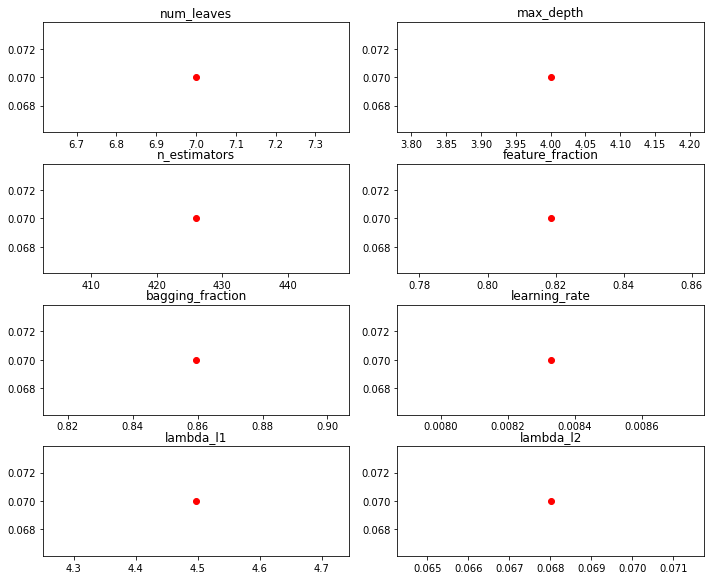

In [ ]:
parameters = ['num_leaves','max_depth','n_estimators','feature_fraction','bagging_fraction','learning_rate','lambda_l1','lambda_l2']
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print("Best " + str(val) + "   =   " + str(best_lgbm[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_lgbm[val],max_acc_lgbm,color = "red")
    axes[i//2,i%2].set_title(val)

In [ ]:
params = { 
            'num_leaves': num_leaves_list[best_lgbm['num_leaves']],
            'max_depth': best_lgbm['max_depth'],
            'n_estimators': best_lgbm['n_estimators'],
            'feature_fraction':best_lgbm['feature_fraction'],
            'bagging_fraction':best_lgbm['bagging_fraction'],
            'learning_rate':best_lgbm['learning_rate'],
            'lambda_l1': best_lgbm['lambda_l1'],
            'lambda_l2':best_lgbm['lambda_l2']
          }
train_data=lgb.Dataset(X_train,label=y_train)

num_round=100
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(X_test)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,y_test),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Accuracy score =  7.000000000000001 %
Execution time =  0:01:29.449974
Prediction time =  0:00:00.006542


# **Fit XGBoost model to the data**

In [ ]:
xgb_hps = {  
            'learning_rate':     hp.loguniform('learning_rate', -5.0, -2.3),
            'max_depth':         hp.choice('max_depth',np.arange(2,16,1,dtype = int)),
            'lambda':            hp.quniform('lambda',0.01, 1.0, 0.01),
            'subsample':        hp.quniform('subsample',0.1,1.0,0.1),
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'min_split_loss' : hp.quniform('min_split_loss',0.4,1.5,0.1)
        }

depth_list = [i for i in range(2,16,1)]

In [ ]:
accuracy_list_xgb = []
def HPO_xgb(xgb_hps):
    model = model = XGBClassifier(**xgb_hps)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy_xgb = accuracy_score(y_pred,y_test).mean()
    accuracy_list_xgb.append(accuracy_xgb)
    return {'loss': -accuracy_xgb, 'status': STATUS_OK }

In [ ]:
trials = Trials()
best_xgb = fmin(fn= HPO_xgb,
            space= xgb_hps,
            algo= tpe.suggest,
            max_evals = 1,
            trials = trials
            )
max_acc_xgb = max(accuracy_list_xgb)
print("Best Hyperparameters for XGBoost are: \n")
best_xgb

100%|██████████| 1/1 [15:02<00:00, 902.81s/it, best loss: -0.41]
Best Hyperparameters for XGBoost are: 



{'colsample_bytree': 0.7000000000000001,
 'lambda': 0.9500000000000001,
 'learning_rate': 0.08170587792850575,
 'max_depth': 7,
 'min_split_loss': 1.4000000000000001,
 'subsample': 0.1}

Best max_depth   =   9
Best subsample   =   0.1
Best learning_rate   =   0.08170587792850575
Best min_split_loss   =   1.4000000000000001
Best lambda   =   0.9500000000000001
Best colsample_bytree   =   0.7000000000000001


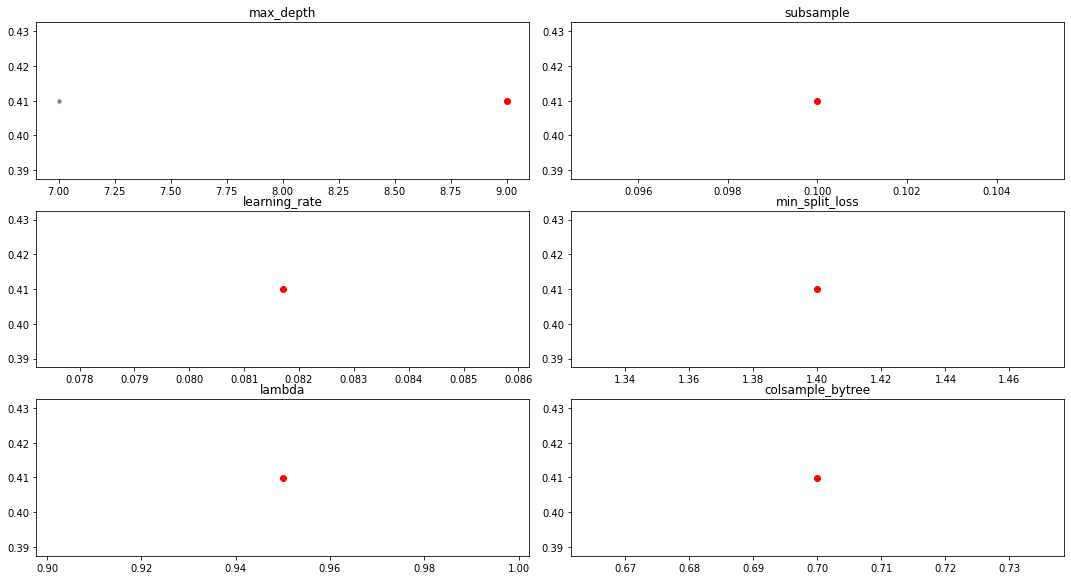

In [ ]:
parameters = ['max_depth','subsample','learning_rate','min_split_loss','lambda','colsample_bytree']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'max_depth':
      best_xgb[val] = depth_list[best_xgb[val]]
    print("Best " + str(val) + "   =   " + str(best_xgb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_xgb[val],max_acc_xgb,color = "red")
    axes[i//2,i%2].set_title(val)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(**best_xgb)
t1=datetime.now()
model.fit(X_train,y_train)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(X_test)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,y_test),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  41.0 %
Execution time =  0:15:04.018050
Prediction time =  0:00:00.053249


# **Results and Plots**

# **1.Accuracy Plot**

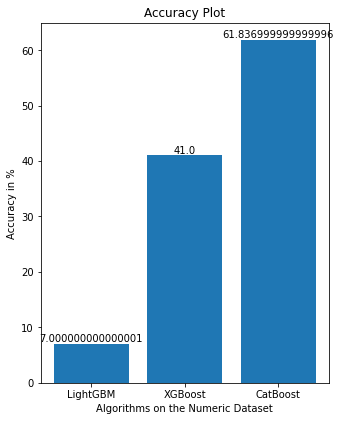

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

# **2.Training Time Plot**

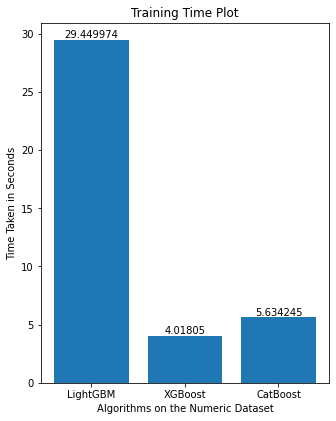

In [ ]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()